<a href="https://colab.research.google.com/github/https-deeplearning-ai/tensorflow-1-public/blob/main/C4/W3/ungraded_labs/C4_W3_Lab_1_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ungraded Lab: Using a Simple RNN for forecasting

In this lab, you will start to use recurrent neural networks (RNNs) to build a forecasting model. In particular, you will:

* build a stacked RNN using `simpleRNN` layers
* use `Lambda` layers to reshape the input and scale the output
* use the Huber loss during training
* use batched data windows to generate model predictions

You will train this on the same synthetic dataset from last week so the initial steps will be the same. Let's begin!

## Imports

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv
import time

## Utilities

In [2]:
def plot_series(x, y, format="-", start=0, end=None, 
                title=None, xlabel=None, ylabel=None, legend=None ):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      label (string) - tag for the line
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    
    # Check if there are more than two series to plot
    if type(y) is tuple:

      # Loop over the y elements
      for y_curr in y:

        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
      plt.legend(legend)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()



In [3]:
import pandas as pd
data=pd.read_csv('D:\DeTaiNam2024\SoLieuHong\HNX30.csv')
data.head

<bound method NDFrame.head of       Unnamed: 0       time    open    high     low   close    volume
0              0  24/8/2017  184.41  188.04  184.35  188.04  18579100
1              1  25/8/2017  188.03  189.23  187.57  188.17  18386500
2              2  28/8/2017  189.37  190.66  187.73  190.30  19843100
3              3  29/8/2017  189.10  191.51  189.05  190.28  18307100
4              4  30/8/2017  190.68  192.53  189.59  189.78  15084300
...          ...        ...     ...     ...     ...     ...       ...
1763        1763  13/9/2024  498.71  505.02  489.15  504.13  21945300
1764        1764  16/9/2024  498.93  505.01  494.31  498.07  21626600
1765        1765  17/9/2024  492.86  504.89  490.08  504.42  26365000
1766        1766  18/9/2024  503.95  510.02  494.12  506.51  32026200
1767        1767  19/9/2024  498.97  509.42  491.88  508.04   6361900

[1768 rows x 7 columns]>

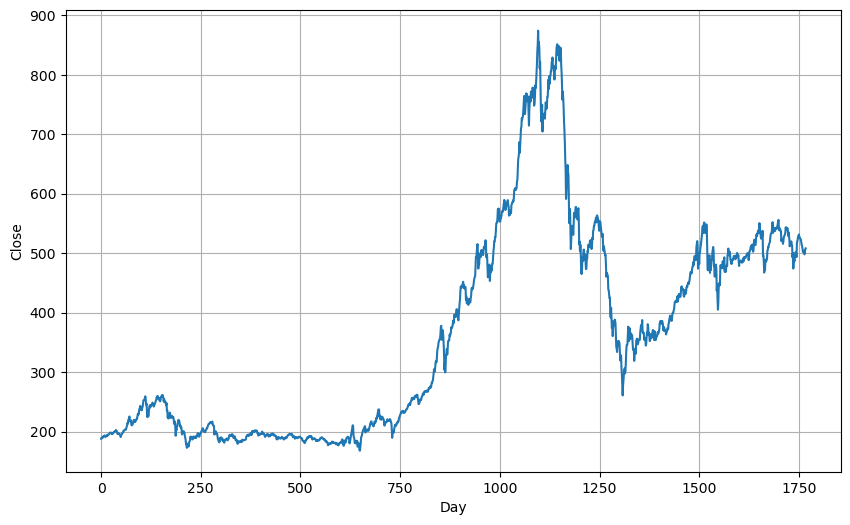

In [4]:
# Initialize lists
time_step = []
close = []

# Open CSV file
with open('D:\DeTaiNam2024\SoLieuHong\HNX30.csv') as csvfile:
  
  # Initialize reader
  reader = csv.reader(csvfile, delimiter=',')
  
  # Skip the first line
  next(reader)
  
  # Append row and sunspot number to lists
  for row in reader:
    time_step.append(int(row[0]))
    close.append(float(row[5]))

# Convert lists to numpy arrays
time_step = np.array(time_step)
series = np.array(close)

# Preview the data
plot_series(time_step, series, xlabel='Day', ylabel='Close')

In [5]:
# Define the split time
split_time = 1500

# Get the train set 
time_train = time_step[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time_step[split_time:]
x_valid = series[split_time:]
# Parameters
window_size = 30
batch_size = 32
shuffle_buffer_size = 500
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """
  
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset
# Generate the dataset windows
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [10]:
import time
start_time = time.time()
# Build the model
model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[window_size]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

# Set the learning rate
learning_rate = 1e-6

# Set the optimizer 
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
history = model.fit(dataset,epochs=100)
end_time = time.time()
train_time_cls = end_time - start_time
print(f'Thời gian huấn luyện mô hình DNN: {train_time_cls:.4f} giây')

Epoch 1/100
46/46 [==============================] - 3s 14ms/step - loss: 422.8883 - mae: 423.3883
Epoch 2/100
46/46 [==============================] - 1s 15ms/step - loss: 140.7641 - mae: 141.2634
Epoch 3/100
46/46 [==============================] - 1s 13ms/step - loss: 153.4186 - mae: 153.9186
Epoch 4/100
46/46 [==============================] - 1s 14ms/step - loss: 149.3672 - mae: 149.8670
Epoch 5/100
46/46 [==============================] - 1s 16ms/step - loss: 142.7824 - mae: 143.2821
Epoch 6/100
46/46 [==============================] - 1s 13ms/step - loss: 144.7171 - mae: 145.2159
Epoch 7/100
46/46 [==============================] - 1s 13ms/step - loss: 146.4015 - mae: 146.9013
Epoch 8/100
46/46 [==============================] - 1s 13ms/step - loss: 146.8214 - mae: 147.3214
Epoch 9/100
46/46 [==============================] - 1s 13ms/step - loss: 146.4329 - mae: 146.9321
Epoch 10/100
46/46 [==============================] - 1s 14ms/step - loss: 145.9658 - mae: 146.4653
Epoch 11/

46/46 [==============================] - 1s 22ms/step - loss: 143.0017 - mae: 143.5010
Epoch 84/100
46/46 [==============================] - 1s 25ms/step - loss: 143.0497 - mae: 143.5493
Epoch 85/100
46/46 [==============================] - 1s 21ms/step - loss: 142.6040 - mae: 143.1032
Epoch 86/100
46/46 [==============================] - 1s 23ms/step - loss: 143.5489 - mae: 144.0479
Epoch 87/100
46/46 [==============================] - 1s 24ms/step - loss: 142.4462 - mae: 142.9458
Epoch 88/100
46/46 [==============================] - 1s 23ms/step - loss: 143.0573 - mae: 143.5564
Epoch 89/100
46/46 [==============================] - 1s 24ms/step - loss: 142.5777 - mae: 143.0768
Epoch 90/100
46/46 [==============================] - 2s 29ms/step - loss: 143.1689 - mae: 143.6681
Epoch 91/100
46/46 [==============================] - 1s 19ms/step - loss: 142.9975 - mae: 143.4968
Epoch 92/100
46/46 [==============================] - 1s 21ms/step - loss: 142.6625 - mae: 143.1620
Epoch 93/100


In [11]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    # Get predictions on the entire dataset
    forecast = model.predict(dataset)
    
    return forecast

9/9 [==============================] - 3s 19ms/step


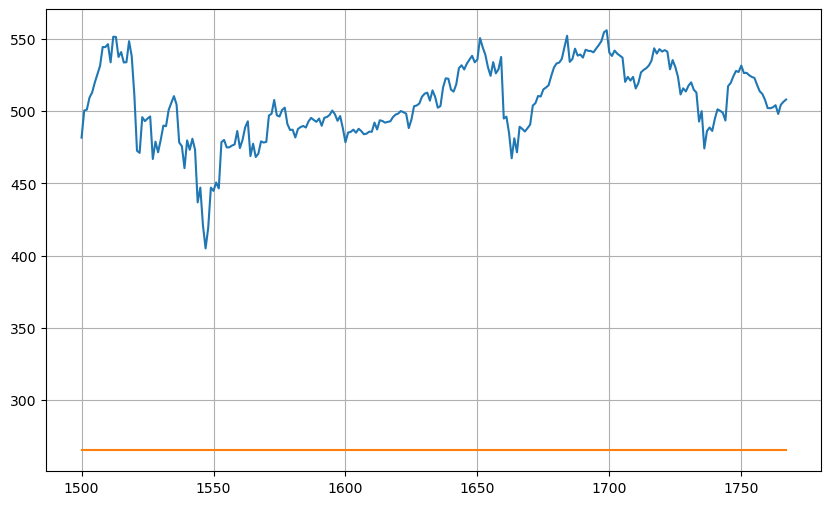

[265.31198 265.31198 265.31198 265.31198 265.31198 265.31198 265.31198
 265.31198 265.31198 265.31198 265.31198 265.31198 265.31198 265.31198
 265.31198 265.31198 265.31198 265.31198 265.31198 265.31198 265.31198
 265.31198 265.31198 265.31198 265.31198 265.31198 265.31198 265.31198
 265.31198 265.31198 265.31198 265.31198 265.31198 265.31198 265.31198
 265.31198 265.31198 265.31198 265.31198 265.31198 265.31198 265.31198
 265.31198 265.31198 265.31198 265.31198 265.31198 265.31198 265.31198
 265.31198 265.31198 265.31198 265.31198 265.31198 265.31198 265.31198
 265.31198 265.31198 265.31198 265.31198 265.31198 265.31198 265.31198
 265.31198 265.31198 265.31198 265.31198 265.31198 265.31198 265.31198
 265.31198 265.31198 265.31198 265.31198 265.31198 265.31198 265.31198
 265.31198 265.31198 265.31198 265.31198 265.31198 265.31198 265.31198
 265.31198 265.31198 265.31198 265.31198 265.31198 265.31198 265.31198
 265.31198 265.31198 265.31198 265.31198 265.31198 265.31198 265.31198
 265.3

In [12]:
# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))
print(results)
# Giả sử x_valid và results là các mảng dự đoán và giá trị thực
x_valid = np.array(x_valid)
results = np.array(results)

# Tính Mean Squared Error
mse = tf.keras.metrics.mean_squared_error(x_valid, results).numpy()
print("MSE:", mse)

# Tính Mean Absolute Percentage Error (MAPE)
non_zero_indices = x_valid != 0  # Đảm bảo không có giá trị 0 trong mẫu
mean_error_percent = np.mean(np.abs((x_valid[non_zero_indices] - results[non_zero_indices]) / x_valid[non_zero_indices]))
accuracy = 1 - mean_error_percent  # Tính accuracy từ MAPE

print("Mean Error Percent:", mean_error_percent)
print("Accuracy:", accuracy)